<a href="https://colab.research.google.com/github/TomazFilgueira/Deep-Learning-with-PyTorch/blob/main/chapter01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 1

In [3]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter1()
# This is needed to render the plots in this chapter
from plots.chapter1 import *

Installing torchviz...
Creating folders...
Finished!


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

# A Simple Regression Problem

$$
\Large y = b + w x + \epsilon
$$

## Data Generation

### Synthetic Data Generation

In [6]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

### Split Train / Test

In [7]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Generated Data - Train'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'Generated Data - Validation'}, xlabel='x', ylabel='y'>],
       dtype=object))

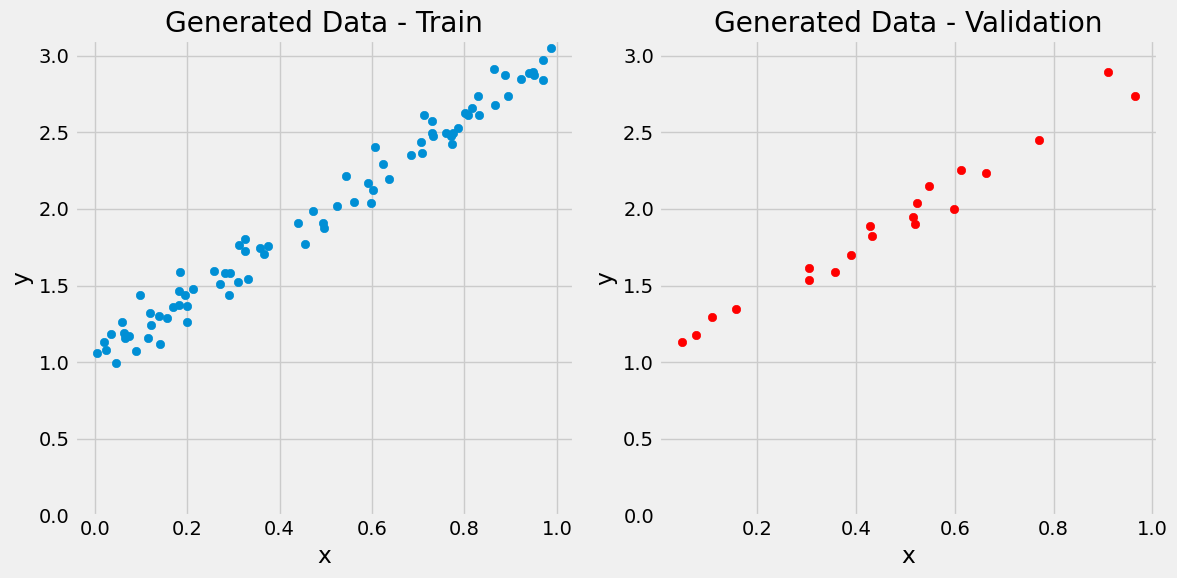

In [ ]:
figure1(x_train, y_train, x_val, y_val)

# PyTorch

## Tensor

In [6]:
scalar = torch.tensor(3.14159)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)
tensor = torch.randn((2, 3, 4), dtype=torch.float)

print(scalar)
print(vector)
print(matrix)
print(tensor)

tensor(3.1416)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[-0.2759,  0.0889, -0.3874,  1.0784],
         [-1.9782,  0.3579,  0.8383,  2.9547],
         [ 0.4272, -1.2272, -1.6232,  0.9993]],

        [[ 0.0443,  0.0738,  1.1307, -0.5610],
         [ 1.9877, -1.5852,  0.1201,  0.8280],
         [ 0.9147,  1.0548,  0.8926,  1.3646]]])


In [ ]:
print(tensor.size(), tensor.shape)

torch.Size([2, 3, 4]) torch.Size([2, 3, 4])


In [ ]:
print(scalar.size(), scalar.shape)

torch.Size([]) torch.Size([])


In [7]:
# We get a tensor with a different shape but it still is
# the SAME tensor
same_matrix = matrix.view(1, 6)
# If we change one of its elements...
same_matrix[0, 1] = 2.
# It changes both variables: matrix and same_matrix
print(matrix)
print(same_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])


In [8]:
# We can use "new_tensor" method to REALLY copy it into a new one
different_matrix = matrix.new_tensor(matrix.view(1, 6))
# Now, if we change one of its elements...
different_matrix[0, 1] = 3.
# The original tensor (matrix) is left untouched!
# But we get a "warning" from PyTorch telling us
# to use "clone()" instead!
print(matrix)
print(different_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 3., 1., 1., 1., 1.]])


<ipython-input-8-bac3a3914f46>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  different_matrix = matrix.new_tensor(matrix.view(1, 6))


In [ ]:
# Lets follow PyTorch's suggestion and use "clone" method
another_matrix = matrix.view(1, 6).clone().detach()
# Again, if we change one of its elements...
another_matrix[0, 1] = 4.
# The original tensor (matrix) is left untouched!
print(matrix)
print(another_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 4., 1., 1., 1., 1.]])


## Loading Data, Devices and CUDA

In [9]:
x_train_tensor = torch.as_tensor(x_train)
x_train.dtype, x_train_tensor.dtype

(dtype('float64'), torch.float64)

In [10]:
float_tensor = x_train_tensor.float()
float_tensor.dtype

torch.float32

In [ ]:
dummy_array = np.array([1, 2, 3])
dummy_tensor = torch.as_tensor(dummy_array)
# Modifies the numpy array
dummy_array[1] = 0
# Tensor gets modified too...
dummy_tensor

tensor([1, 0, 3])

In [ ]:
dummy_tensor.numpy()

array([1, 0, 3])

### Defining your device

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

Tesla T4


### Cell 1.3

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
back_to_numpy = x_train_tensor.cpu().numpy()

## Creating Parameters

In the next few pages, I will present **four** chunks of code showing different attempts at creating parameters.

The first three attempts are shown to build up to a solution.
1. The first one only works well if you use **CPU TENSORs**
1. The second one uses **GPU TENSORs** and doesn’t work at all.
1. The third one works, but it is too verbose.
1. The recommended way of creating parameters is the last: Notebook Cell 1.4.


In [ ]:
# FIRST
# Initializes parameters "b" and "w" randomly, ALMOST as we
# did in Numpy since we want to apply gradient descent on
# these parameters we need to set REQUIRES_GRAD = TRUE
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [ ]:
# SECOND
# But what if we want to run it on a GPU? We could just
# send them to device, right?
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)
# Sorry, but NO! The to(device) "shadows" the gradient...

tensor([0.3367], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([0.1288], device='cuda:0', grad_fn=<ToCopyBackward0>)


We succeeded in sending them to another device, but we "lost" the gradients somehow, since there is no more `requires_grad=True`


In [ ]:
# THIRD
# We can either create regular tensors and send them to
# the device (as we did with our data)
torch.manual_seed(42)
b = torch.randn(1, dtype=torch.float).to(device)
w = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
b.requires_grad_()
w.requires_grad_()
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


### Cell 1.4

In [ ]:
# FINAL
# We can specify the device at the moment of creation
# RECOMMENDED!

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
print(b, w)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


# Autograd

`Autograd` is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule, or anything like it.


## backward
 It will **compute gradients** for all (gradient-requiring) tensors involved in the computation of a given variable.


### Cell 1.5

In [ ]:
# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train_tensor

# Step 2 - Computes the loss
# We are using ALL data points, so this is BATCH gradient descent
# How wrong is our model? That's the error!
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3 - Computes gradients for both "b" and "w" parameters
# No more manual computation of gradients!
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_tensor * error).mean()
loss.backward()

In [ ]:
print(error.requires_grad, yhat.requires_grad, \
      b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)

True True True True
False False


## grad

In [ ]:
print(b.grad, w.grad)

tensor([-6.7762], device='cuda:0') tensor([-3.8878], device='cuda:0')


In [ ]:
# Just run the two cells above one more time

## zero_

Because grad is **accumulative**, every time we use the gradients to update the parameters, we need to zero the gradients afterward. And that’s what `zero_()` is good for.


In [ ]:
# This code will be placed *after* Step 4
# (updating the parameters)
b.grad.zero_(), w.grad.zero_()

(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

## Updating Parameters

### Cell 1.6

In [ ]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor

    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    # No more manual computation of gradients!
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()
    # We just tell PyTorch to work its way BACKWARDS
    # from the specified loss!
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    #b = b - lr * b.grad
    #w = w - lr * w.grad
    #print(b)

    # SECOND ATTEMPT - using in-place Python assigment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    #b -= lr * b.grad
    #w -= lr * w.grad

    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of
    # the gradient computation. Why is that? It boils
    # down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad

    # PyTorch is "clingy" to its computed gradients, we
    # need to tell it to let it go...
    b.grad.zero_()
    w.grad.zero_()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## no_grad



```
# This is what we used in the THIRD ATTEMPT...
with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad
```



# Dynamic Computation Graph

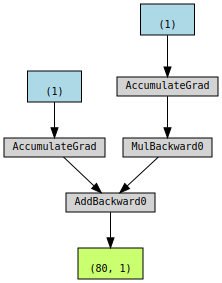

In [ ]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train_tensor

# Step 2 - Computes the loss
# We are using ALL data points, so this is BATCH gradient
# descent. How wrong is our model? That's the error!
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# We can try plotting the graph for any python variable:
# yhat, error, loss...
make_dot(yhat)

▪​ blue boxes ((1)s): these boxes correspond to the tensors we use as **parameters**, the ones we’re asking PyTorch to compute gradients for

​▪​ gray boxes (MulBackward0 and AddBackward0): **Python operations** that involve `gradient-computing` tensors or its dependencies

​▪​ green box ((80, 1)): the tensor used as the **starting point for the computation** of gradients (assuming the backward() method is called from the variable used to visualize the graph)—they are computed from the bottom-up in a graph



What would happen to the computation graph if we set requires_grad to False for our parameter b?


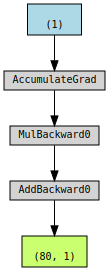

In [ ]:
b_nograd = torch.randn(1, requires_grad=False, \
                       dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

yhat = b_nograd + w * x_train_tensor

make_dot(yhat)

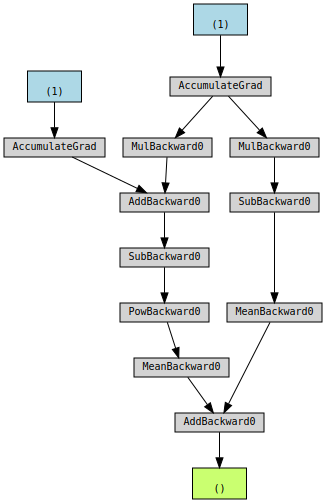

In [ ]:
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

yhat = b + w * x_train_tensor
error = yhat - y_train_tensor
loss = (error ** 2).mean()

# this makes no sense!!
if loss > 0:
    yhat2 = w * x_train_tensor
    error2 = yhat2 - y_train_tensor

# neither does this :-)
loss += error2.mean()

make_dot(loss)

# Optimizer

So far, we’ve been **manually updating** the parameters using the computed gradients. That’s probably fine for two parameters, but what if we had a whole lot of them? We need to use one of PyTorch’s optimizers, like `SGD`, `RMSprop`, or `Adam`.



## step / zero_grad

In [ ]:
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

### Cell 1.7

In [ ]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor

    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate. No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()

    # No more telling Pytorch to let gradients go!
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


# Loss

In [ ]:
# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
loss_fn

MSELoss()

Notice that `nn.MSELoss() `is **NOT the loss function itself**: We do not pass predictions and labels to it! Instead, as you can see, it returns another function, which we called `loss_fn`: That is **the actual loss function.**

We can pass a prediction and a label to it and get the corresponding loss value:



In [ ]:
# This is a random example to illustrate the loss function
predictions = torch.tensor([0.5, 1.0])
labels = torch.tensor([2.0, 1.3])
loss_fn(predictions, labels)

tensor(1.1700)

### Cell 1.8

In [14]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor

    # Step 2 - Computes the loss
    # No more manual loss!
    # error = (yhat - y_train_tensor)
    # loss = (error ** 2).mean()
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


In [15]:
loss

tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

In [17]:
loss.detach().cpu().numpy()

array(0.00804466, dtype=float32)

In [18]:
print(loss.item(), loss.tolist())

0.008044655434787273 0.008044655434787273


# Model

### Cell 1.9

Creating a Manual Linear Regression Class

`forward(self, x):` It performs the actual computation; that is, it outputs a prediction, given the input x.

You should call the whole model instead, as in `model(x)`, to perform a forward pass and output predictions.




In [21]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))

    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.w * x

## Parameters

In [22]:
torch.manual_seed(42)
# Creates a "dummy" instance of our ManualLinearRegression model
dummy = ManualLinearRegression()
list(dummy.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

## state_dict

In [ ]:
dummy.state_dict()

OrderedDict([('b', tensor([0.3367])), ('w', tensor([0.1288]))])

## device

IMPORTANT: We need to **send our model to the same device where the data is**. If our data is made of GPU tensors, our model must "live" inside the GPU as well.


In [23]:
torch.manual_seed(42)
# Creates a "dummy" instance of our ManualLinearRegression model
# and sends it to the device
dummy = ManualLinearRegression().to(device)

## Forward Pass

The forward pass is the moment when the model **makes predictions** using current regressor B and W

**Remember:** You should make predictions calling `model(x)`.

DO NOT call `model.forward(x)`!

Otherwise, your model’s hooks will not work (if you have them).



### Cell 1.10

In [24]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?!?

    # Step 1 - Computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


## Train Mode

In PyTorch, models have a `train()` method, which, somewhat disappointingly, does NOT perform a training step. Its only purpose is to set the model to training mode.

Why is this important? Some models may use mechanisms like Dropout, for instance, which have **distinct behaviors** during training and evaluation phases.

Never forget to include `model.train()` in your training loop!

## Nested Models



We are implementing a single-feature linear regression, one input and one output, so the corresponding linear model would look like this:



In [37]:
linear = nn.Linear(1, 1)
linear

Linear(in_features=1, out_features=1, bias=True)

In [40]:
print(linear.state_dict())
list(linear.parameters())

OrderedDict([('weight', tensor([[0.8815]])), ('bias', tensor([-0.7336]))])


[Parameter containing:
 tensor([[0.8815]], requires_grad=True),
 Parameter containing:
 tensor([-0.7336], requires_grad=True)]

The former parameter **b** is the `bias`, and our former parameter **w** is the `weight` (your values will be different since I haven’t set up a random seed for this example).


### Cell 1.11 - Building a model using PyTorch’s Linear model



In [16]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear model
        # with single input and single output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Now it only takes a call
        self.linear(x)

Now, if we call the `parameters()` method of this model, PyTorch will figure out the parameters of its attributes recursively.


In [17]:
torch.manual_seed(42)
dummy = MyLinearRegression().to(device)
print(list(dummy.parameters()),"\n")

print(dummy.state_dict())

[Parameter containing:
tensor([[0.7645]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.8300], device='cuda:0', requires_grad=True)] 

OrderedDict([('linear.weight', tensor([[0.7645]], device='cuda:0')), ('linear.bias', tensor([0.8300], device='cuda:0'))])


## Sequential Models

### Cell 1.12

In [ ]:
torch.manual_seed(42)
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')),
             ('0.bias', tensor([0.8300], device='cuda:0'))])

## Layers

A Linear model can be seen as a layer in a neural network.

In the figure below, the hidden layer would be **nn.Linear(3, 5)** (since it takes three inputs—from the input layer—and generates five outputs), and the output layer would be **nn.Linear(5, 1)** (since it takes five inputs—the outputs from the hidden layer—and generates a single output).

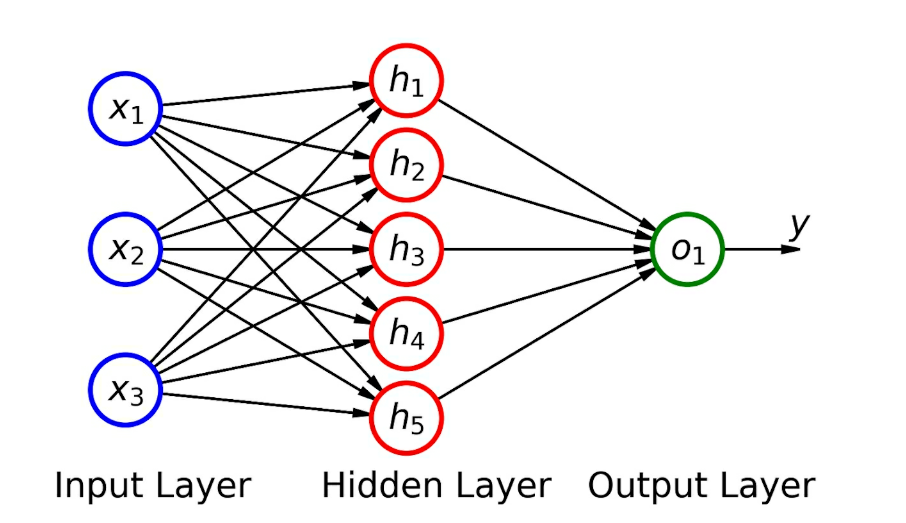


$output = bias + weight * Input$

If we use `Sequential()` to build it; it looks like this:


In [43]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)

model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4414,  0.4792, -0.1353],
                      [ 0.5304, -0.1265,  0.1165],
                      [-0.2811,  0.3391,  0.5090],
                      [-0.4236,  0.5018,  0.1081],
                      [ 0.4266,  0.0782,  0.2784]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2060, -0.0524, -0.1816,  0.2967, -0.3530]], device='cuda:0')),
             ('1.bias', tensor([-0.2062], device='cuda:0'))])

Since this sequential model does not have attribute names, `state_dict()` uses numeric prefixes. You can also use a model’s `add_module()` method to name the layers:


In [2]:
torch.manual_seed(42)
# Building the model from the figure above
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
model.to(device)

NameError: name 'torch' is not defined

# Putting It All Together

## Data Preparation

### Data Preparation V0

In [8]:
%%writefile data_preparation/v0.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

Writing data_preparation/v0.py


We know we have to run the **full sequence to train a model**: data preparation, model configuration, and model training. In Chapter 2, we’ll gradually improve each of these parts, versioning them inside each corresponding folder. So, saving them to files allows us to run a full sequence using different versions without having to duplicate code.

We are using the following two magics to better organize our code:

 ​▪​ `%%writefile`: As its name says, it writes the contents of the cell to a file, but it does not run it, so we need to use yet another magic.

 ​▪​ `%run`: It runs the named file inside the notebook as a program—but independent of the rest of the notebook, so we need to use the -i option to make all variables available, from both the notebook and the file (technically speaking, the file is executed in IPython’s namespace).


In [12]:
%run -i data_preparation/v0.py

## Model Configuration

* Model

* loss function (which needs to be chosen according to your model)

* an optimizer (although some people may disagree with this choice, it makes it easier to further organize the code)



### Model Configuration V0

In [13]:
%%writefile model_configuration/v0.py

# This is redundant now, but it won't be when we introduce
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v0.py


In [14]:
%run -i model_configuration/v0.py

## Model Training

* Step 1: compute model’s predictions
* Step 2: compute the loss ​
* Step 3: compute the gradients
* Step 4: Update parameters



### Model Training V0

In [18]:
%%writefile model_training/v0.py

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

Writing model_training/v0.py


In [19]:
%run -i model_training/v0.py

In [21]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
